# **Emojify World! (Text to Emoji with GloVe and LSTM)**

## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
        - [1.3.1 - sentence_to_avg](#1-3-1)
    - [1.4 - Implement the Model](#1-4)
        - [1.4.1 - model](#1-4-1)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - sentences_to_indices](#2-1)
    - [2.2 - pretrained_embedding_layer](#2-2)
    - [2.3 - Building the Emojifier-V2](#2-3)
        - [2.3.1 - Emojify_V2](#2-3-1)
    - [2.4 - Train the Model](#2-4)

<a name='0'></a>
## Packages

In [ ]:
### v3.0

In [ ]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

In [ ]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [ ]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [ ]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

#### One-hot Encoding

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [ ]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [ ]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


<a name='ex-1'></a>
### 1.3.1 - sentence_to_avg

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    avg = np.zeros(word_to_vec_map[any_word].shape)
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count +=1
    if count > 0:
        avg = avg / count
    return avg

In [ ]:
### YOU CANNOT EDIT THIS CELL

# BEGIN UNIT TEST
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.array_equal(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"

    print("\033[92mAll tests passed!")

sentence_to_avg_test(sentence_to_avg)

# END UNIT TEST

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


<a name='1-4'></a>
### 1.4 - Implement the Model

<a name='ex-2'></a>
### 1.4.1 - model

In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    any_word = list(word_to_vec_map.keys())[0]
    cost = 0

    m = Y.shape[0]
    n_y = len(np.unique(Y))
    n_h = word_to_vec_map[any_word].shape[0]

    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    Y_oh = convert_to_one_hot(Y, C = n_y)

    for t in range(num_iterations):
        for i in range(m):

            avg = sentence_to_avg(X[i], word_to_vec_map)

            z = np.dot(W, avg) + b
            a = softmax(z)

            cost = -np.sum(Y_oh[i] * np.log(a))

            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
### YOU CANNOT EDIT THIS CELL

# UNIT TEST
def model_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Training set. Sentences composed of a_* words will be of class 0 and sentences composed of c_* words will be of class 1
    X = np.asarray(['a a_s synonym_of_a a_n c_sw', 'a a_s a_n c_sw', 'a_s  a a_n', 'synonym_of_a a a_s a_n c_sw', " a_s a_n",
                    " a a_s a_n c ", " a_n  a c c c_e missing",
                   'c c_nw c_n c c_ne', 'c_e c c_se c_s', 'c_nw c a_s c_e c_e', 'c_e a_nw c_sw', 'c_sw c c_ne c_ne'])

    Y = np.asarray([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

    np.random.seed(10)
    pred, W, b = model(X, Y, word_to_vec_map, 0.0025, 110)

    assert W.shape == (2, 2), "W must be of shape 2 x 2"
    assert np.allclose(pred.transpose(), Y), "Model must give a perfect accuracy"
    assert np.allclose(b[0], -1 * b[1]), "b should be symmetric in this example"

    print("\033[92mAll tests passed!")

model_test(model)

Epoch: 0 --- cost = 0.05105772513207823
Accuracy: 0.9166666666666666
Epoch: 100 --- cost = 0.00970311068897676
Accuracy: 1.0
All tests passed!


In [ ]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


<a name='1-5'></a>
### 1.5 - Examining Test Set Performance

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


#### The Model Matches Emojis to Relevant Words

In [ ]:
X_my_sentences = np.array(["i treasure you", "i love you", "funny lol", "lets play with a ball", "food is ready", "today is not good"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i treasure you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
today is not good 😄


#### Confusion Matrix


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


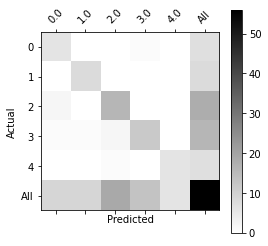

In [ ]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<a name='2'></a>
## 2 - Emojifier-V2: Using LSTMs in Keras

### Packages

In [ ]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='ex-3'></a>
### 2.1 - sentences_to_indices

In [ ]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]

    X_indices = np.zeros((m, max_len))

    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j =  j + 1
    return X_indices

In [ ]:
### YOU CANNOT EDIT THIS CELL

# UNIT TEST
def sentences_to_indices_test(target):

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(["i", "like", "learning", "deep", "machine", "love", "smile", '´0.=']):
        word_to_index[val] = idx + 1;

    max_len = 4
    sentences = np.array(["I like deep learning", "deep ´0.= love machine", "machine learning smile", "$"]);
    indexes = target(sentences, word_to_index, max_len)
    print(indexes)

    assert type(indexes) == np.ndarray, "Wrong type. Use np arrays in the function"
    assert indexes.shape == (sentences.shape[0], max_len), "Wrong shape of ouput matrix"
    assert np.allclose(indexes, [[1, 2, 4, 3],
                                 [4, 8, 6, 5],
                                 [5, 3, 7, 0],
                                 [0, 0, 0, 0]]), "Wrong values. Debug with the given examples"

    print("\033[92mAll tests passed!")

sentences_to_indices_test(sentences_to_indices)

[[1. 2. 4. 3.]
 [4. 8. 6. 5.]
 [5. 3. 7. 0.]
 [0. 0. 0. 0.]]
All tests passed!


In [ ]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


### 2.2 - pretrained_embedding_layer

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_size = len(word_to_index) + 1
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    emb_matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [ ]:
### YOU CANNOT EDIT THIS CELL

# UNIT TEST
def pretrained_embedding_layer_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;

    np.random.seed(1)
    embedding_layer = target(word_to_vec_map, word_to_index)

    assert type(embedding_layer) == Embedding, "Wrong type"
    assert embedding_layer.input_dim == len(list(word_to_vec_map.keys())) + 1, "Wrong input shape"
    assert embedding_layer.output_dim == len(word_to_vec_map['a']), "Wrong output shape"
    assert np.allclose(embedding_layer.get_weights(),
                       [[[ 3, 3], [ 3, 3], [ 2, 4], [ 3, 2], [ 3, 4],
                       [-2, 1], [-2, 2], [-1, 2], [-1, 1], [-1, 0],
                       [-2, 0], [-3, 0], [-3, 1], [-3, 2], [ 0, 0]]]), "Wrong vaulues"
    print("\033[92mAll tests passed!")


pretrained_embedding_layer_test(pretrained_embedding_layer)

All tests passed!


In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


<a name='2-4'></a>
### 2.3 - Building the Emojifier-V2

<a name='ex-5'></a>
### 2.3.1 - Emojify_V2

In [ ]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)

    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)

    model = Model(sentence_indices, X)

    return model

In [ ]:
### YOU CANNOT EDIT THIS CELL

# UNIT TEST
from tensorflow.python.keras.engine.functional import Functional

def Emojify_V2_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;

    maxLen = 4
    model = target((maxLen,), word_to_vec_map, word_to_index)

    assert type(model) == Functional, "Make sure you have correctly created Model instance which converts \"sentence_indices\" into \"X\""

    expectedModel = [['InputLayer', [(None, 4)], 0], ['Embedding', (None, 4, 2), 30], ['LSTM', (None, 4, 128), 67072, (None, 4, 2), 'tanh', True], ['Dropout', (None, 4, 128), 0, 0.5], ['LSTM', (None, 128), 131584, (None, 4, 128), 'tanh', False], ['Dropout', (None, 128), 0, 0.5], ['Dense', (None, 5), 645, 'linear'], ['Activation', (None, 5), 0]]
    comparator(summary(model), expectedModel)


Emojify_V2_test(Emojify_V2)

All tests passed!


In [ ]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

#### Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-4'></a>
### 2.4 - Train the Model

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 25ms/step - loss: 1.5768 - accuracy: 0.2273
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 1.5038 - accuracy: 0.3182
Epoch 3/50
5/5 [==============================] - 0s 37ms/step - loss: 1.4362 - accuracy: 0.3939
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 1.3486 - accuracy: 0.4848
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 1.2351 - accuracy: 0.5682
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 1.0849 - accuracy: 0.6667
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.9367 - accuracy: 0.6818
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8411 - accuracy: 0.6818
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.7145 - accuracy: 0.7348
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5922 - accuracy: 0.7879
Epoch 11/50
5/5 [============

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 4ms/step - loss: 0.5131 - accuracy: 0.8750

Test accuracy =  0.875


In [ ]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾


In [ ]:
x_test = np.array(['I cannot play'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I cannot play ⚾
